In [3]:
import pandas as pd
import geopandas as gpd
import numpy as np

# matplotlib
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.patches import Circle
import matplotlib.dates as mdates
%matplotlib inline

import datetime

import contextily as cx

import seaborn as sns
import os
from tqdm import tqdm

import shapely
from shapely.geometry import LineString, Point
from collections import Counter

import iteround

from sklearn.neighbors import KDTree

!pip install seaborn
!pip install iteround
!pip install contextily
!pip install matplotlib-scalebar

### Load data needed

In [8]:
# get lakes
lake_path = "C:/Users/kaghog/Documents/SA/lake/g1s20.shp"

df_lakes = gpd.read_file(lake_path, geometry="geometry", crs="EPSG:2056").to_crs("epsg:2056")
df_lakes.crs = "epsg:2056"
df_lakes.head()

,GMDNR,GMDNAME,SEE_HA,X_MIN,X_MAX,Y_MIN,Y_MAX,X_CNTR,Y_CNTR,E_MIN,E_MAX,N_MIN,N_MAX,E_CNTR,N_CNTR,geometry
0,9040,Greifensee,830,691665,695946,241896,247739,693800,245200,2691665,2695946,1241896,1247739,2693800,1245200,"POLYGON ((2692710.105 1247539.156, 2693290.110..."
1,9050,Zürichsee,8808,682601,714353,227657,247369,690500,235000,2682601,2714353,1227657,1247369,2690500,1235000,"POLYGON ((2690574.161 1236105.158, 2690884.159..."
2,9073,Thunersee,4784,614257,630110,167064,177247,621500,171200,2614257,2630110,1167064,1177247,2621500,1171200,"POLYGON ((2627650.882 1170385.277, 2628447.875..."
3,9089,Brienzersee,2977,634122,646789,170863,178693,640600,175000,2634122,2646789,1170863,1178693,2640600,1175000,"POLYGON ((2634104.753 1171525.283, 2634714.738..."
4,9148,Bielersee / Lac de Bienne,3970,572052,584660,209652,220433,578500,213800,2572052,2584660,1209652,1220433,2578500,1213800,"POLYGON ((2581862.847 1214634.546, 2580704.868..."


In [5]:
# get districts
geom_data_path = "C:/Users/kaghog/Documents/SA"
df_districts = gpd.read_file("%s/city_districts/data/stzh.adm_stadtkreise_v.shp" % geom_data_path,
                       encoding="latin1"
                      ).to_crs("epsg:2056")

# clean up
df_districts.crs = "epsg:2056"
df_districts = df_districts.rename({"knr": "district_id", "kname": "district_name"}, axis=1)
df_districts = df_districts[["district_id", "district_name", "geometry"]].sort_values("district_id").reset_index(drop=True)
df_districts

,district_id,district_name,geometry
0,1,Kreis 1,"POLYGON ((2683358.477 1246403.556, 2683218.937..."
1,2,Kreis 2,"POLYGON ((2682296.566 1247016.328, 2682356.984..."
2,3,Kreis 3,"POLYGON ((2682296.566 1247016.328, 2682253.264..."
3,4,Kreis 4,"POLYGON ((2682296.566 1247016.328, 2682280.117..."
4,5,Kreis 5,"POLYGON ((2680537.632 1249894.533, 2680539.926..."
5,6,Kreis 6,"POLYGON ((2684316.434 1250651.586, 2684314.614..."
6,7,Kreis 7,"POLYGON ((2683860.979 1246723.697, 2683862.124..."
7,8,Kreis 8,"POLYGON ((2684280.850 1243932.550, 2683368.541..."
8,9,Kreis 9,"POLYGON ((2680390.466 1248340.821, 2680389.532..."
9,10,Kreis 10,"POLYGON ((2680537.632 1249894.533, 2680532.138..."


In [32]:
#get data
df = pd.read_csv("C:/Users/kaghog/git/sx-eth/eqasim-java/scenario/testDrtZones/ITERS/it.5/5.drt_legs_drt.csv", sep=";")

#convert xy to point geometry and then to a geodataframe
df['origin_geometry'] = [Point(xy) for xy in zip(df.fromX, df.fromY)] 
df['destination_geometry'] = [Point(xy) for xy in zip(df.toX, df.toY)] 

df['geometry'] = df['origin_geometry']
df = gpd.GeoDataFrame(df)
df.crs = "epsg:2056"

#create trip ids for unique identification of each trip
df["trip_id"] = [x for x in range(1, len(df)+1)]
df.head()

C:\APPS\Anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:112: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  values = construct_1d_object_array_from_listlike(values)


,departureTime,personId,vehicleId,fromLinkId,fromX,fromY,toLinkId,toX,toY,waitTime,...,travelTime,travelDistance_m,directTravelDistance_m,fareForLeg,latestDepartureTime,latestArrivalTime,origin_geometry,destination_geometry,geometry,trip_id
0,14090.0,201740003100294,drt1853,43432,2680960.49,1247907.23,972286,2681292.90,1246301.32,92.0,...,304.0,2370.44,2370.44,0,14690,14659.32,POINT (2680960.49 1247907.23),POINT (2681292.9 1246301.32),POINT (2680960.490 1247907.230),1
1,20394.0,201740003028284,drt2337,199217,2681198.89,1248025.61,246162,2680254.63,1249577.36,61.0,...,339.0,3627.25,3627.25,0,20994,21064.84,POINT (2681198.89 1248025.61),POINT (2680254.63 1249577.36),POINT (2681198.890 1248025.610),2
2,21703.0,201740003336656,drt1678,675408,2682050.18,1255754.71,925551,2683054.40,1255429.15,61.0,...,334.0,1557.34,1557.34,0,22303,22388.82,POINT (2682050.18 1255754.71),POINT (2683054.4 1255429.15),POINT (2682050.180 1255754.710),3
3,23489.0,201740002998470,drt1350,541592,2683287.88,1249835.70,534179,2683131.06,1249110.50,96.0,...,197.0,1171.76,1171.76,0,24089,23944.55,POINT (2683287.88 1249835.7),POINT (2683131.06 1249110.5),POINT (2683287.880 1249835.700),4
4,24834.0,201740003251660,drt2339,327283,2686042.63,1245901.99,796053,2686123.38,1245421.11,61.0,...,324.0,2857.00,2857.00,0,25434,25470.72,POINT (2686042.63 1245901.99),POINT (2686123.38 1245421.11),POINT (2686042.630 1245901.990),5


### function to impute zones
Here we do not fix by distance so default is set to false

In [10]:
#functions to input zones by points in a dataframe

def to_gpd(df, x="x", y="y", crs="epsg:2056", coord_type=""):
    df["geometry"] = [geo.Point(*coord) for coord in tqdm(zip(df[x], df[y]), total=len(df), desc="Converting %s coordinates" % coord_type)]
    df = gpd.GeoDataFrame(df)
    df.crs = crs

    if not crs == "epsg:2056":
        df = df.to_crs("epsg:2056")
        df.crs = "epsg:2056"

    return df

def impute(df_points, df_zones, point_id_field, zone_id_field, fix_by_distance=False, chunk_size=10000,
           zone_type="", point_type=""):
    assert (type(df_points) == gpd.GeoDataFrame)
    assert (type(df_zones) == gpd.GeoDataFrame)

    assert (point_id_field in df_points.columns)
    assert (zone_id_field in df_zones.columns)
    assert (not zone_id_field in df_points.columns)

    df_original = df_points
    df_points = df_points[[point_id_field, "geometry"]]
    df_zones = df_zones[[zone_id_field, "geometry"]]

    print("Imputing %d %s zones onto %d %s points by spatial join..."
          % (len(df_zones), zone_type, len(df_points), point_type))

    result = []
    chunk_count = max(1, int(len(df_points) / chunk_size))
    for chunk in tqdm(np.array_split(df_points, chunk_count)):
        result.append(gpd.sjoin(df_zones, chunk, op="contains", how="right"))
    df_points = pd.concat(result).reset_index()

    if "left_index" in df_points: del df_points["left_index"]
    if "right_index" in df_points: del df_points["right_index"]

    invalid_mask = pd.isnull(df_points[zone_id_field])

    if fix_by_distance and np.any(invalid_mask):
        print("  Fixing %d points by centroid distance join..." % np.count_nonzero(invalid_mask))
        coordinates = np.vstack([df_zones["geometry"].centroid.x, df_zones["geometry"].centroid.y]).T
        kd_tree = KDTree(coordinates)

        df_missing = df_points[invalid_mask]
        coordinates = np.vstack([df_missing["geometry"].centroid.x, df_missing["geometry"].centroid.y]).T
        indices = kd_tree.query(coordinates, return_distance=False).flatten()

        df_points.loc[invalid_mask, zone_id_field] = df_zones.iloc[indices][zone_id_field].values

    return pd.merge(df_original, df_points[[point_id_field, zone_id_field]], on=point_id_field, how="left")

### Assigning points to zones

In [33]:
## identify zones for origin location!!

df = impute(df, df_districts, "trip_id", "district_id").drop("geometry", axis=1)

#Since we are not fixing by distance, checking how many points are outside the districts
print("no. of trips outside the district: ", sum(pd.isna(df["district_id"])))

df = pd.merge(df, df_districts, on="district_id", how="right") #merge on right to ensure all districts are showing
df.head()

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\APPS\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3437: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 47.55it/s]

Imputing 12  zones onto 91  points by spatial join...
no. of trips outside the district:  32


,departureTime,personId,vehicleId,fromLinkId,fromX,fromY,toLinkId,toX,toY,waitTime,...,directTravelDistance_m,fareForLeg,latestDepartureTime,latestArrivalTime,origin_geometry,destination_geometry,trip_id,district_id,district_name,geometry
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,Kreis 1,"POLYGON ((2683358.477 1246403.556, 2683218.937..."
1,41129.0,2.017400e+14,drt2145,1042216.0,2682447.20,1243893.49,462887.0,2682569.48,1244236.90,61.0,...,748.27,0.0,41729.0,41480.62,POINT (2682447.2 1243893.49),POINT (2682569.48 1244236.9),41.0,2.0,Kreis 2,"POLYGON ((2682296.566 1247016.328, 2682356.984..."
2,41549.0,2.017400e+14,drt2145,462887.0,2682569.48,1244236.90,1042216.0,2682447.20,1243893.49,61.0,...,570.62,0.0,42149.0,41870.83,POINT (2682569.48 1244236.9),POINT (2682447.2 1243893.49),44.0,2.0,Kreis 2,"POLYGON ((2682296.566 1247016.328, 2682356.984..."
3,14090.0,2.017400e+14,drt1853,43432.0,2680960.49,1247907.23,972286.0,2681292.90,1246301.32,92.0,...,2370.44,0.0,14690.0,14659.32,POINT (2680960.49 1247907.23),POINT (2681292.9 1246301.32),1.0,3.0,Kreis 3,"POLYGON ((2682296.566 1247016.328, 2682253.264..."
4,25099.0,2.017400e+14,drt420,64717.0,2681250.58,1247780.60,175313.0,2682735.29,1249107.09,61.0,...,3309.46,0.0,25699.0,25790.21,POINT (2681250.58 1247780.6),POINT (2682735.29 1249107.09),7.0,3.0,Kreis 3,"POLYGON ((2682296.566 1247016.328, 2682253.264..."


In [34]:
#only eleven districts have trips in this sample df
df["district_id"].unique()

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.])

In [36]:
## computing metrics for plot

metrics = ["waitTime","directTravelDistance_m"] #can add others later

mean_metrics = df.groupby("district_id")[metrics].mean().reset_index()
#mean_metrics = pd.concat([mean_metrics, pd.DataFrame(df[metrics].mean()).T]).fillna("All").reset_index(drop=True)

for col in metrics:
    if "time" in col.lower():
        mean_metrics[col] /= 60
mean_metrics = mean_metrics.round(1)
mean_metrics

,district_id,waitTime,directTravelDistance_m
0,1.0,NaN,NaN
1,2.0,1.0,659.4
2,3.0,1.3,2172.9
3,4.0,1.2,1544.2
4,5.0,1.0,1677.1
5,6.0,1.1,1778.0
6,7.0,1.1,1612.4
7,8.0,1.0,2861.2
8,9.0,1.0,2042.4
9,10.0,1.2,1126.9


In [37]:
#add Zurich or zonal overlay
def zurich_overlay(ax, number_districts=True, district_col="knr"):
    # add lake
    city_shape = shapely.ops.unary_union([geo for geo in df_districts["geometry"]])
    f = df_lakes["geometry"].intersects(city_shape)
    df_lakes.loc[f, "geometry"].intersection(city_shape).plot(facecolor="skyblue", edgecolor="dodgerblue", ax=ax)

    # add districts with numbers
    df_districts.plot(facecolor="none", edgecolor="black", ax=ax)
    if number_districts:
        for _, row in df_districts.iterrows():    
            ax.text(row["geometry"].centroid.x, row["geometry"].centroid.y, str(row[district_col]), color="black", fontsize=20)
        
    return ax

def add_scalebar(ax):
    # add scale bar
    scalebar = ScaleBar(1, font_properties={'size': 20}, location="lower left", frameon=False, box_color=None)
    ax.add_artist(scalebar)
    scalebar.get_fixed_value()
    
    return ax

def add_north(ax):
    
    # add north arrow
    x_min = ax.get_xbound()[0]
    x_max = ax.get_xbound()[1]
    dx = x_max - x_min

    y_min = ax.get_ybound()[0]
    y_max = ax.get_ybound()[1]
    dy = y_max - y_min

    ax.text(x=x_min, y=y_min + dy*0.1, s='N', fontsize=30)
    ax.arrow(x=x_min + 225, y=y_min + dy*0.14, 
             dx=0, dy=0, width=0,
             length_includes_head=False,
             head_width=500, head_length=500, overhang=.2, facecolor='k', edgecolor=None, linewidth=0, 
             head_starts_at_zero=False)
    
    return ax

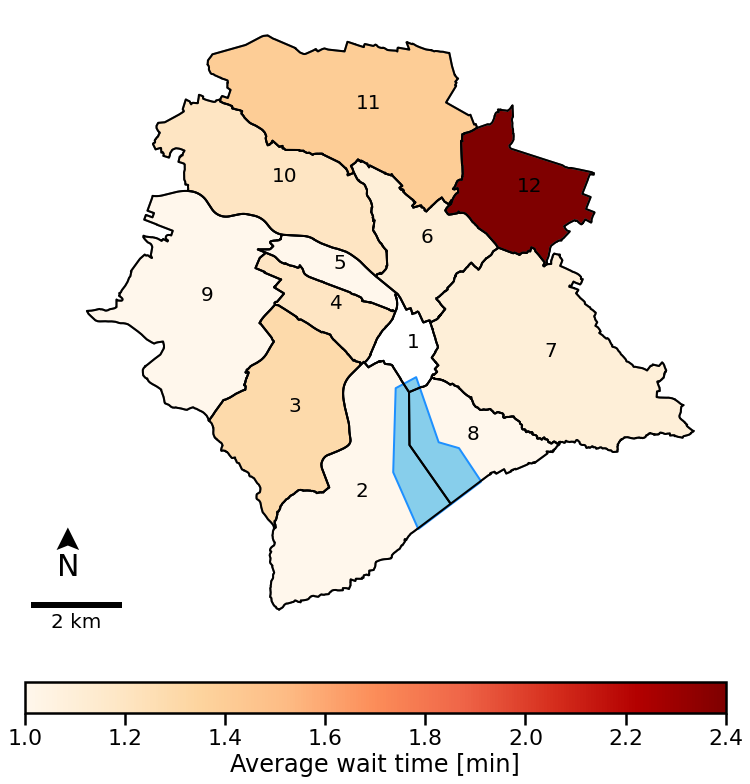

In [38]:
## change me
figure_dir = "C:/Users/kaghog/Documents/SA"


sns.set_context("poster")
fig, ax = plt.subplots(1, 1, figsize=(13, 13))

# allow to adjust colormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax)
cax = divider.new_vertical(size='5%', pad=0.6, pack_start = True)
fig.add_axes(cax)

temp = gpd.GeoDataFrame(pd.merge(mean_metrics.iloc[0:12, :], df_districts)) #exclude the mean for all at the end
temp.plot("waitTime", 
          ax=ax, 
         #  vmin=2.0,
         #  vmax=6.0,
          legend=True,
          legend_kwds=dict(label="Average wait time [min]",
                           orientation="horizontal",
                           shrink=0.7,
                           cax=cax
                           ),
          alpha=1.0, 
          cmap='OrRd', 
          edgecolor="grey",
          )

ax = zurich_overlay(ax, number_districts=True, district_col="district_id")
ax = add_scalebar(ax)

# add north arrow
x_min = ax.get_xbound()[0]
x_max = ax.get_xbound()[1]
dx = x_max - x_min

y_min = ax.get_ybound()[0]
y_max = ax.get_ybound()[1]
dy = y_max - y_min

ax.text(x=x_min, y=y_min + dy*0.1, s='N', fontsize=30)
ax.arrow(x=x_min + 250, y=y_min + dy*0.14, 
       dx=0, dy=0, width=0,
       length_includes_head=False,
       head_width=500, head_length=500, overhang=.2, facecolor='k', edgecolor=None, linewidth=0, 
       head_starts_at_zero=False)

ax.set_axis_off()

# plt.savefig("%s/figures/parking_search.search_time.by_district.pdf" % figure_dir.rstrip("/"), bbox_inches='tight')
# plt.savefig("%s/figures/parking_search.search_time.by_district.png" % figure_dir.rstrip("/"), bbox_inches='tight')